In [19]:
from torch.utils.data import Dataset, DataLoader
from dataset import AdverseWeatherDataset
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from model import Model, NLDis
import time
import datetime
from torch.autograd import Variable  
import kornia.metrics as metrics
import sobel
import ssim_torch
from statistics import mean

In [20]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = r'./data/train'
VAL_DIR = r'./data/val'
BATCH_SIZE = 1
NUM_WORKERS = 4
EPOCHS = 2
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
LEARNING_RATE_D = 1e-5
START_EPOCH = 0
ALPHA = 0.6

# LEARNING_RATE = 2e-4
# IMAGE_SIZE = 256
# CHANNELS_IMG = 3
# L1_LAMBDA = 100
# LAMBDA_GP = 10
# NUM_EPOCHS = 500
# LOAD_MODEL = False
# SAVE_MODEL = False
# CHECKPOINT_DISC = "disc.pth.tar"
# CHECKPOINT_GEN = "gen.pth.tar"

In [21]:
training_set = AdverseWeatherDataset(root_dir=TRAIN_DIR, is_train=True)
val_set = AdverseWeatherDataset(root_dir=VAL_DIR, is_train=False)

datasets = {'train': training_set, 'val': val_set}
dataloaders = {x: DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'val']}

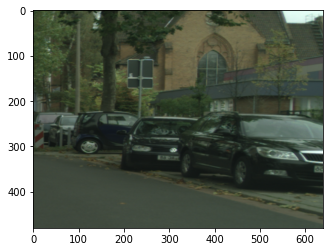

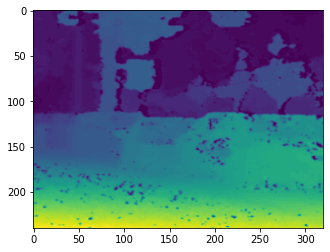

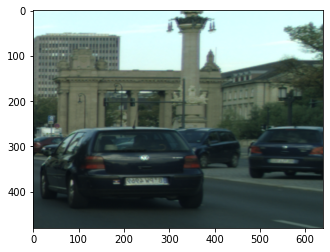

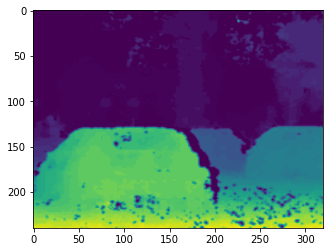

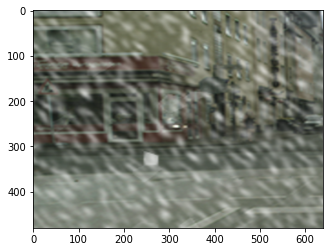

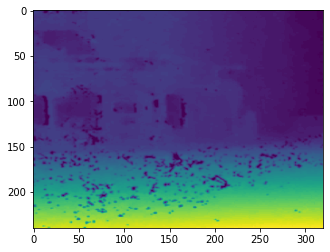

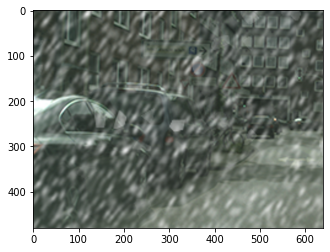

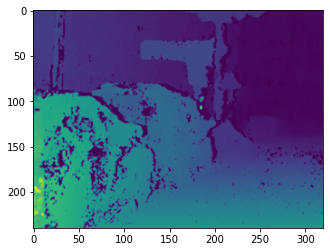

<Figure size 432x288 with 0 Axes>

In [22]:
for i in range(len(datasets['train'])):
    sample = datasets['train'][i]
    
    # tr = transforms.ToPILImage()
    plt.imshow(sample['image'].permute(1, 2, 0))
    plt.figure()
    plt.imshow(sample['depth'].permute(1, 2, 0))
    plt.figure()
    if i == 3:
        plt.show()
        break

In [23]:
import matplotlib
import matplotlib.cm
import numpy as np

# normalizes the depth maps 
def DepthNorm(depth, maxDepth=1000.0): 
    return maxDepth / depth

# defines the Structural Similarity (SSIM) index map between the two images
def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    ssim = metrics.SSIM(window_size=11,max_val=val_range)
    return ssim(img1, img2)

def adjust_learning_rate(optimizer, epoch):
    lr = LEARNING_RATE * (0.1 ** (epoch // 3))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# computes and stores average and current values of each node in the network
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        


In [24]:
device_ids = [Id for Id in range(torch.cuda.device_count())]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

min_loss = 1000

model = Model().cuda() # constructs the model and move it to GPU to enables CUDA operations
model = nn.DataParallel(model, device_ids=device_ids)

netD = NLDis(1)
netD = netD.cuda()

print('  + Number of params in model: {}'.format(
    sum(p.numel() for p in model.parameters() if p.requires_grad)))

print('  + Number of params in netD: {}'.format(
    sum(p.numel() for p in netD.parameters() if p.requires_grad)))

optimizer = torch.optim.Adam( model.parameters(), LEARNING_RATE, weight_decay=WEIGHT_DECAY) # defines the optimizations algorithm
optimizer_D = torch.optim.Adam(netD.parameters(), LEARNING_RATE_D, weight_decay=0)

# start training
for epoch in range(START_EPOCH, EPOCHS):
  adjust_learning_rate(optimizer, epoch)
  
  batch_time = AverageMeter() # batch_time stores stats about batch training time
  losses = AverageMeter() # losses holds stats about loss function
  losses_D = AverageMeter()
  
  # switch the model to train mode
  model.train()
  netD.train()
  
  cos = nn.CosineSimilarity(dim=1, eps=0)
  get_gradient = sobel.Sobel().cuda()
  
  l1 = nn.L1Loss()
  ssim = ssim_torch.SSIM()
  mse = nn.MSELoss()
  
  # # creates and saves the initial model to disk
  # path='./checkpoints/'+str(epoch)+'.pth'        
  # torch.save(model.state_dict(), path)
  
  end = time.time()
  
  train_epoch_losses = []
  
  N = len(dataloaders['train'])

  # iterates through the data batches
  for i, sample_batched in enumerate(dataloaders['train']):
        
    # defines the tensors to hold the input and output, 
    # and wraps them in Variable to support automatic differentiation during backprogration
    image = Variable(sample_batched['image'].cuda())
    depth = Variable(sample_batched['depth'].cuda(non_blocking=True))

    ones = torch.ones(depth.size(0), 1, depth.size(2),depth.size(3)).float().cuda()
    ones = torch.autograd.Variable(ones)

    optimizer.zero_grad() # sets the gradients of all model parameters to 0

    # normalize dep
    depth = DepthNorm(depth)

    # forward pass computes the predicted depth map by passing image to the model
    output = model(image) 
    outputD = netD(output)
    
    target_real = Variable(torch.full((outputD.size()), 1, device='cuda:0'), requires_grad=False)
    target_fake = Variable(torch.full((outputD.size()), 0, device='cuda:0'), requires_grad=False)

    depth_grad = get_gradient(depth)
    output_grad = get_gradient(output)
    depth_grad_dx = depth_grad[:, 0, :, :].contiguous().view_as(depth)
    depth_grad_dy = depth_grad[:, 1, :, :].contiguous().view_as(depth)
    output_grad_dx = output_grad[:, 0, :, :].contiguous().view_as(depth)
    output_grad_dy = output_grad[:, 1, :, :].contiguous().view_as(depth)

    depthormal = torch.cat((-depth_grad_dx, -depth_grad_dy, ones), 1)
    output_normal = torch.cat((-output_grad_dx, -output_grad_dy, ones), 1)



    loss_depth = torch.log(torch.abs(output - depth) + 0.5).mean()
    loss_dx = torch.log(torch.abs(output_grad_dx - depth_grad_dx) + 1.0).mean()
    loss_dy = torch.log(torch.abs(output_grad_dy - depth_grad_dy) + 1.0).mean()
    loss_normal = torch.abs(1 - cos(output_normal, depthormal)).mean()
    
    # loss(mean absolute error) between the predicted and ground truth depth map is calculated
    loss_l1 = l1(output.to(torch.float32), depth.to(torch.float32))
    # loss_l1 = l1(output, depth)
    
    # computes ssim between predicted and ground truth
    # loss_ssim = torch.clamp((1 - ssim(output, depth, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)

    loss_ssim = 1 - ssim(output.to(torch.float32), depth.to(torch.float32))
    
    loss_l1SSIM = (ALPHA * loss_l1) + ((1-ALPHA) * loss_ssim)
    
    loss_adv = mse(outputD.to(torch.float32), target_real.to(torch.float32))

    # combined loss
    # loss = (1.0 * l_ssim.mean().item()) + (0.1 * l_depth)
    loss = loss_depth + loss_normal + (loss_dx + loss_dy)  + loss_adv
    
    # updates the losses AverageMeter object with the new loss 
    losses.update(loss.data.item(), image.size(0))
    
    # perform backward pass through the network and computes the gradient of loss
    loss.backward()
    
    # iterates though all the weights on the networkk and updates them
    optimizer.step()
    
    train_epoch_losses.append(loss.item())
    
    # Training the Discriminator
    optimizer_D.zero_grad()
    pred_real = netD(depth)
    loss_D_real = mse(pred_real.to(torch.float32), target_real.to(torch.float32))
    
    # Fake loss
    # output = fake_buffer.push_and_pop(output)
    pred_fake = netD(output.detach())
    loss_D_fake = mse(pred_fake.to(torch.float32), target_fake.to(torch.float32))
    loss_D = loss_D_real + loss_D_fake
    losses_D.update(loss_D.item(), image.size(0))
    loss_D.backward()
    optimizer_D.step()

    # calculates the elapsed time for one pass throught the network
    batch_time.update(time.time() - end)
    end = time.time()
    eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

    train_epoch_loss = mean(train_epoch_losses)

    if train_epoch_loss < min_loss:
      min_loss = train_epoch_loss
      path='epoch_{:1}_model.pth'.format(epoch)        
      torch.save(model.state_dict(), path)

    # log progress
    niter = epoch*N+i
    if i % 5 == 0:
      # print to console
      print('Epoch: [{0}][{1}/{2}]\t'
      'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t'
      'ETA {eta}\t'
      'Loss {loss.val:.4f} ({loss.avg:.4f})'
      .format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))

  # saves the updated model after each epoch
  path='./checkpoints/final_model.pth'        
  torch.save(model.state_dict(), path)   

cuda
  + Number of params in model: 14424057
  + Number of params in netD: 6958913
Epoch: [0][0/34800]	Time 0.400 (0.400)	ETA 3:52:11	Loss 5.6393 (5.6393)
Epoch: [0][5/34800]	Time 0.096 (1.486)	ETA 0:55:32	Loss 6.8173 (5.7890)
Epoch: [0][10/34800]	Time 0.098 (1.971)	ETA 0:56:46	Loss 5.5146 (5.7815)
Epoch: [0][15/34800]	Time 0.098 (2.461)	ETA 0:56:36	Loss 6.3512 (5.6541)
Epoch: [0][20/34800]	Time 0.099 (2.945)	ETA 0:57:10	Loss 5.3736 (5.5723)
Epoch: [0][25/34800]	Time 0.098 (3.431)	ETA 0:57:00	Loss 5.2818 (5.4352)
Epoch: [0][30/34800]	Time 0.096 (3.913)	ETA 0:55:45	Loss 4.4467 (5.3982)
Epoch: [0][35/34800]	Time 0.097 (4.396)	ETA 0:56:20	Loss 5.2824 (5.4229)
Epoch: [0][40/34800]	Time 0.097 (4.887)	ETA 0:56:29	Loss 4.5801 (5.3983)
Epoch: [0][45/34800]	Time 0.096 (5.371)	ETA 0:55:25	Loss 6.5267 (5.4261)
Epoch: [0][50/34800]	Time 0.096 (5.856)	ETA 0:55:52	Loss 5.8402 (5.4443)
Epoch: [0][55/34800]	Time 0.096 (6.346)	ETA 0:55:50	Loss 4.8428 (5.4440)
Epoch: [0][60/34800]	Time 0.098 (6.828)	ETA

KeyboardInterrupt: 